times assume cosmology from planck2015:

Omega_m = 0.31, Omega_l = 0.69, Omega_b = 0.048,
h = 0.68, sigma_8 = 0.82, n_s = 0.97

i scale-factor redshift time[Gyr] lookback-time[Gyr] time-width[Myr]

332 0.587579608  0.701897025  7.265212114  6.471003908  26.1623

In [20]:
import gizmo_analysis as gizmo  # rename these packages for brevity
import utilities as ut  # rename these packages for brevity

import numpy as np

from astropy.cosmology import Planck18

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from scipy.stats import gaussian_kde
import astropy.units as u
import astropy.cosmology.units as cu

In [21]:
redshift = 0.702 * cu.redshift
omega_m = 0.31
omega_l = 0.69
omega_b = 0.048
h = 0.68
sigma_8 = 0.82
n_s = 0.97
# Planck cosmological parameters for cosmological simulation.

In [3]:
gizmo.io

<module 'gizmo_analysis.gizmo_io' from '/home/baparker/code/gizmo_analysis/gizmo_io.py'>

In [4]:
simulation_directory = '/home/baparker/m12r_res7100/'

In [5]:
part = gizmo.io.Read.read_snapshots('all', 'redshift', 0.702, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  home/baparker/m12r_res7100/snapshot_times.txt

* input redshift = 0.702:  using snapshot index = 332, redshift = 0.702


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/baparker/m12r_res7100/output/snapdir_332/snapshot_332.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 60327928 particles
    dark2     (id = 2): 6226512 particles
    gas       (id = 0): 58520742 particles
    star      (id = 4): 1820812 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    snapshot_332.0.hdf5
    snapshot_332.1.hdf5
    snapshot_332.2.hdf5
    snapshot_332.3.hdf5

* reading cosmological parameters from:  home/baparker/m12r_res7100/initial_condition/ic_L172_m12r.conf

* checking sanity of particle properties


# in gizmo_analysis.gizmo_track.ParticleCoordinate():
  read 1 host (position, velocity, principal 

In [6]:
part['gas'].keys()

dict_keys(['position', 'density', 'electron.fraction', 'temperature', 'mass', 'massfraction', 'hydrogen.neutral.fraction', 'id.child', 'id.generation', 'id', 'potential', 'size', 'sfr', 'velocity'])

In [7]:
part['star'].keys()

dict_keys(['position', 'mass', 'massfraction', 'id.child', 'id.generation', 'id', 'potential', 'form.scalefactor', 'velocity'])

In [8]:
gas_loc = part['gas']['position']
gas_temp = part['gas']['temperature']
gas_den = part['gas']['density']

In [9]:
np.shape(gas_loc)

(58520742, 3)

In [71]:
scale = 1000

x = gas_loc[::scale, 0] * u.kpc
y = gas_loc[::scale, 1] * u.kpc
z = gas_loc[::scale, 2] * u.kpc
# Locations in comoving kpc

temp = gas_temp[::scale] * u.K
# Gas cell temperature in K
dens = gas_den[::scale] * u.Msun / (u.kpc**3)
# Gas density in Msun/kpc^3

nH = part['gas'].prop('number.density')[::scale] / (u.cm**3)
# Number density in [1/cm^3]

mass_frac = part['gas']['massfraction'][::scale, 0]
# Total metal mass fraction of gas cells

metallicity = part['star'].prop('metallicity.metals')[::scale] * u.dex
metallicity_fe = part['star'].prop('metallicity.fe')[::scale] * u.dex
# Metallicity in dex

In [72]:
from astropy.visualization import quantity_support
quantity_support()  

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fe161110850>

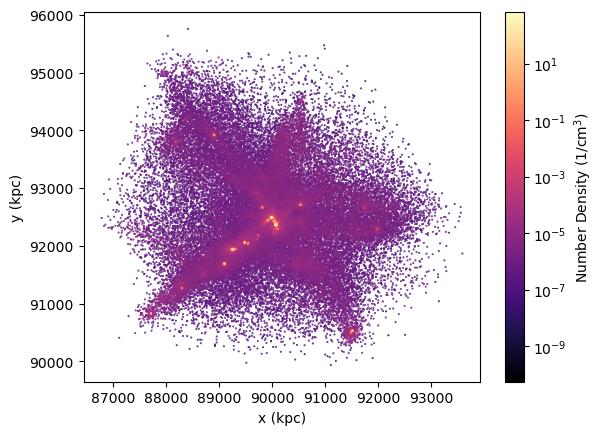

In [85]:
ind = np.argsort(nH)

plt.scatter(x[ind], y[ind], c = nH[ind], s=0.2, norm=cl.LogNorm(), cmap = 'magma')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(label = r'Number Density (1/cm$^3$)')
# BP Plotting the number density of gas throughout the galaxy.

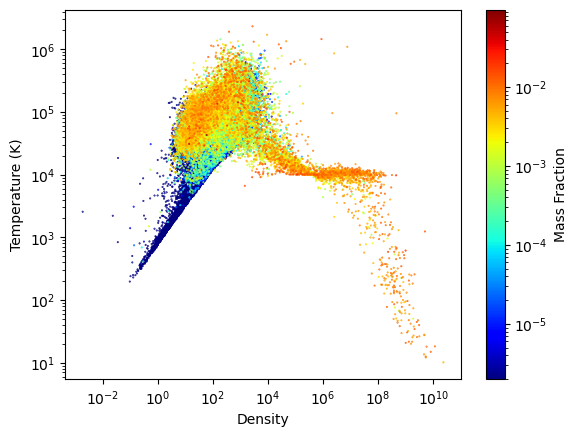

In [86]:
ind = np.argsort(mass_frac)

plt.scatter(dens[ind], temp[ind], c = mass_frac[ind], s=0.2, norm=cl.LogNorm(), cmap='jet')
plt.xlabel('Density')
plt.ylabel('Temperature (K)')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label = 'Mass Fraction')
#plt.title('

# BP Plotting the phase diagram (density temperature) number density of all the gas particles.

In [265]:
scale = 5
stars = part['star']
stars_x = stars['position'][::scale, 0] * u.kpc
stars_y = stars['position'][::scale, 1] * u.kpc
stars_z = stars['position'][::scale, 2] * u.kpc
stars_mass = stars['mass'][::scale] * u.Msun

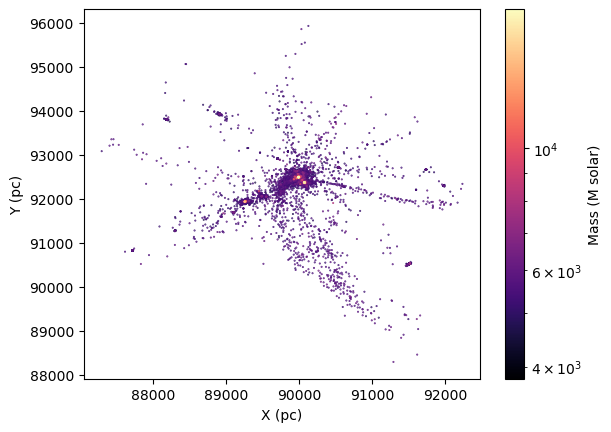

In [266]:
ind = np.argsort(stars_mass)

plt.scatter(stars_x[ind], stars_y[ind], c = stars_mass[ind], s=0.2, norm=cl.LogNorm(), cmap = 'magma')
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.colorbar(label = 'Mass (M solar)')
# BP Plotting the location of all the stars in the galaxy colored by mass.

# Running Cloudy Grids

In order to calculate the emission at 

### Generating grids

In [15]:
print(np.shape(gas_loc))
print(gas_loc)

(58520742, 3)
[[89989.84442847 92487.91714467 89785.6486778 ]
 [89989.94669158 92488.21120778 89785.61509848]
 [89989.96879914 92488.219327   89785.43677803]
 ...
 [89676.49491334 94747.12503472 90378.84053559]
 [89671.24133381 94766.20127441 90398.54762909]
 [89697.12885878 94760.90584652 90413.32676949]]


In [23]:
print(len(x), len(y))

585208 585208


### Assume optically thin. Run in 2D grid

In [262]:
n = 5
gridx = np.linspace(x.min(), x.max(), n+1)
gridy = np.linspace(y.min(), y.max(), n+1)

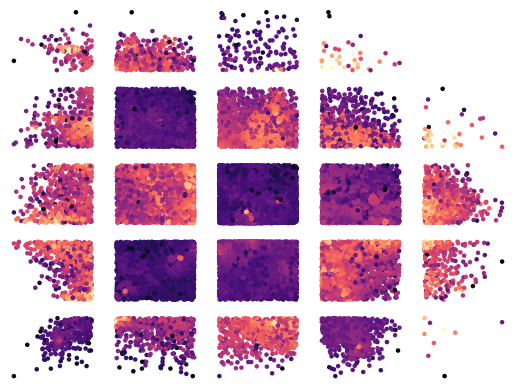

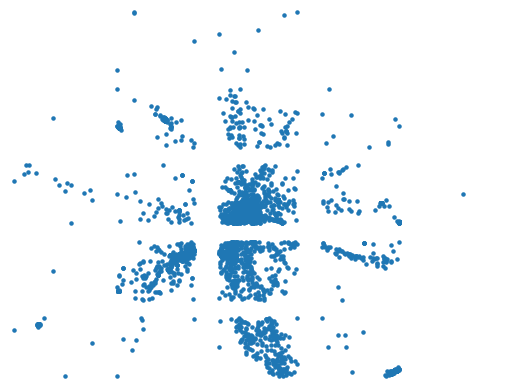

In [276]:
fig, ax = plt.subplots(n,n)
fig_star, ax_star = plt.subplots(n,n)

nH_avg = u.Quantity(np.zeros((n,n)), 1/u.cm**3)
grid_star_masses = u.Quantity(np.zeros((n,n,1000000)), u.Msun)

for i in range(len(gridx)-1):
    for j in range(len(gridy)-1):
        grid_ind = (x >= gridx[i]) & (x <= gridx[i+1]) & (y >= gridy[j]) & (y <= gridy[j+1])
        # BP get all gas particles within the cell
        
        grid_ind_star = (stars_x >= gridx[i]) & (stars_x <= gridx[i+1]) & (stars_y >= gridy[j]) & (stars_y <= gridy[j+1])

        ax[n-j-1, i].scatter(x[grid_ind], y[grid_ind], s=5, c = nH[grid_ind], norm=cl.LogNorm(), cmap = 'magma')
        ax[n-j-1, i].axis('off')
        # Plot to visualize the grid
        
        ax_star[n-j-1, i].scatter(stars_x[grid_ind_star], stars_y[grid_ind_star], s=5)#, c = nH[grid_ind], norm=cl.LogNorm(), cmap = 'magma')
        ax_star[n-j-1, i].axis('off')
        
        nH_avg[i, j] = np.mean(nH[grid_ind])
        
        stars_mass_grid = stars_mass[grid_ind_star]
        
        grid_star_masses[i, j, :len(stars_mass_grid)] = stars_mass_grid
        
plt.show()

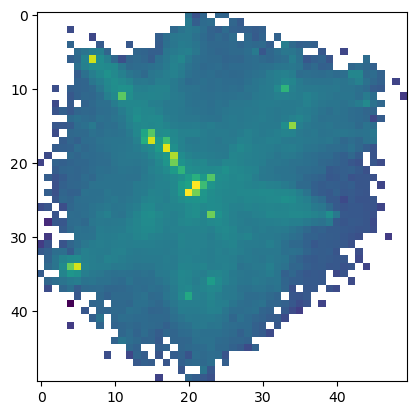

In [255]:
plt.imshow(nH_avg.value, norm=cl.LogNorm())

In [58]:
test = np.argsort(z)
z_test = z[ind]

dist = []

for i in range(100):
    dist.append(z[i+1] - z[i])

size = part['gas']['size'] * u.kpc
print(size.mean())

dist = u.Quantity(dist)
dist_avg = dist.mean()

print(dist_avg)
# Average particle cell box side length

5.212678909301758 kpc
5.630352241170185 kpc


In [29]:
print(len(x_grid))

72


In [34]:
print(np.shape(grid))

(3, 65, 72, 71)


In [ ]:
title example input
hden 5 # log of hydrogen density, cmË†-3
blackbody 5e4 K # spectral shape is a 50000K blackbody
# intensity of blackbody is set with
# ionization parameter so starting radius is not needed
ionization parameter -2

In [ ]:
# Start by ignoring contributions from stars

In [ ]:
# Open geometry

In [28]:
(z.max() - z.min())

-6270.04387035087